# Neural Texture Transfer
<img src='items/Titre.jpg' alt="Drawing" style="width: 200px"/>

In [0]:
!# pip install tensorflow==2.0.0-alpha0 

In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,20)
mpl.rcParams['axes.grid'] = False
import numpy as np
from PIL import Image
import scipy.misc

import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
kp_image = kp_image.img_to_array
from ntUtils import *
import IPython.display

## Image Preprocessing

* Slicer takes an image and splits it into pieces according to the parameter split. 
* Recomp is the corresponding inverse function

In [0]:
def slicer(path_to_img,  split = (2,2), mode = None, size = None):
    img = Image.open(path_to_img)
    if mode == 'texture':
        img = img.resize(size)
    imgwidth, imgheight = img.size
    n_split_w, n_split_h = split
    height = imgheight//n_split_h; width = imgwidth//n_split_w
    
    imgs = []
    for i in range(0,n_split_h*height,height):
        for j in range(0,n_split_w*width,width):
            box = (j, i, j+width, i+height)
            x = img.crop(box)
            imgs.append(kp_image(x))
    return tf.constant(np.array(imgs), dtype='uint8')
  
 
def recomp(img, split=(2,2)):
    def concat(arr, axis):
        if len(arr) > 1:
            return np.concatenate(arr, axis = axis)
        else:
            return arr
    n_split_w, n_split_h = split
    imgs = []
    for i in range(n_split_h):
        imgs.append(concat(img[i*n_split_w:(i+1)*n_split_w], axis = 1))
    tout = concat(imgs, axis = 0)
    image = Image.fromarray(tout)
    return image

## Compute Features

* gram_matrix calculates the correlation of texture features for a batch of pictures
* get_deep_outputs computes some features for the content and texture

In [0]:
def gram_matrix(input_tensor):
    batch,  height, width, channels = [int(d) for d in input_tensor.shape]
    tensor = tf.reshape(input_tensor, [batch, height*width, channels])
    # Get the product height*width
    n = tf.shape(tensor)[1]
    gram = tf.matmul(tensor, tensor, transpose_a=True)
    #gram = tf.nn.dropout(gram, 0.8)
    #gram = tf.nn.max_pool(tf.reshape(gram,[1,channels,channels,1]),ksize = [1,2, 2,1], strides=[1, 1, 1, 1],padding= 'VALID')
    return gram / tf.cast(n, tf.float32)

In [0]:
def get_deep_outputs(model, inputs, num_texture_layers):
    
    t = int(inputs.shape[0])//2
    outputs = model(inputs)
    color_outputs = [layer[:t] for layer in outputs[num_texture_layers:]]
    bw_outputs = [gram_matrix(layer[t:2*t]) for layer in outputs[:num_texture_layers]]
    nogram_outputs = [layer[t:2*t] for layer in outputs[:num_texture_layers]]

    
    return color_outputs, bw_outputs, nogram_outputs

## Compute losses
* get_loss computes the mean squared error of a tensor
* compute_loss builds the graph that it iterated over
* get_grads computes the gradients

**Note** : the losses are not blended into one but are seperated across batches

In [0]:
  def get_loss(tensor1, tensor2):
    reduce_space = list(range(1,len(tensor1.shape)))
    return tf.reduce_mean(tf.square(tensor1 - tensor2), reduce_space)

In [0]:
def compute_loss(model, loss_weights, img_sync, const_outputs, content_image):
    
    content_output, texture_output, nogram_outputs = const_outputs
    num_texture_layers = len(texture_output)
    num_content_layers = len(content_output)
    
    img_sync_bw = turn_var_bw(img_sync) # Deprocess, turn to grayscale and then reprocess
    var_inputs = tf.concat([img_sync, img_sync_bw], axis = 0)
    img_sync_output, img_sync_bw_output, img_nogram_outputs = get_deep_outputs(model, var_inputs, num_texture_layers)
    
    texture_loss = 0
    content_loss = 0
    nogram_loss = 0
    
    # Accumulate texture losses from all layers
    w_text = 1.0 / float(num_texture_layers)
    for texture_feat, var_bw_feat in zip(texture_output, img_sync_bw_output):
        texture_loss += w_text * get_loss(texture_feat, var_bw_feat)
    
    # Accumulate texture losses from all layers
    #w_text = 1.0 / float(num_texture_layers)
    for texture_feat, var_bw_feat in zip(nogram_outputs, img_nogram_outputs):
        nogram_loss += w_text * get_loss(texture_feat, var_bw_feat)
    
    # Accumulate content losses from all layers
    w_cont = 1.0 / float(num_content_layers)
    for content_feat, var_feat in zip(content_output, img_sync_output):
        content_loss += w_cont * get_loss(content_feat, var_feat)
    
    direct_weight, content_weight, nogram_weight, texture_weight = loss_weights
    texture_loss *= texture_weight
    content_loss *= content_weight
    nogram_loss *= nogram_weight
    
    direct_loss = direct_weight*get_loss(img_sync, content_image)
   
    total_loss = texture_loss + content_loss + direct_loss+ nogram_loss
    
    return total_loss

In [0]:
def get_grads(args):
    with tf.GradientTape() as tape: 
        loss = compute_loss(**args)
    grads = tape.gradient(loss, args['img_sync'])
    return grads, loss

In [0]:
content_path = '/content/gdrive/My Drive/Neural-Texture-Transfer/lea.jpg'
texture_path = '/content/gdrive/My Drive/Neural-Texture-Transfer/proco.jpg'


In [0]:
content_layers = ['block1_conv1', 'block5_conv2'] 
#content_layers = ['block5_conv2']

texture_layers = ['block1_conv1',
                  'block2_conv1','block3_conv1'
                 #,'block4_conv1'#, 'block5_conv1'
               ]


In [0]:
def neural_texture_train(content_path, texture_path, layers, split,loss_weights, num_iter=1000):
    
    content_layers, texture_layers = layers
    num_content_layers = len(content_layers)
    num_texture_layers = len(texture_layers)
    
    model = get_model(texture_layers, content_layers) 
    for layer in model.layers:
        layer.trainable = False
        
    content_image = slicer(content_path, split=split)
    content_image = load_and_process_img(content_image) # Make ready for the model
    
    size = Image.open(content_path).size
    texture_image = slicer(texture_path, size = size, mode='texture', split=split)
    texture_image = turn_bw(texture_image) # turn into grayscale
    texture_image = load_and_process_img(texture_image) # Make ready for the model
    
    img_sync = tf.Variable(content_image)
    
    
    const_inputs = tf.concat([content_image, texture_image], axis = 0)
    const_outputs = get_deep_outputs(model, const_inputs, num_texture_layers)
    
    lr = 10
    opt = tf.optimizers.Adam(learning_rate=lr, beta_1=0.99, epsilon=1e-1)
    
    args = {'model': model,'loss_weights': loss_weights,'img_sync': img_sync, 
            'const_outputs': const_outputs, 'content_image': content_image, }
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means ; max_vals = 255 - norm_means
    interval = 90; loss_track = [1]*5
    
    for i in range(num_iter):
  
        grads, loss = get_grads(args)
        opt.apply_gradients([(grads, img_sync)])
        clipped = tf.clip_by_value(img_sync, min_vals, max_vals)
        img_sync.assign(clipped)
        
        l = loss.numpy().mean()
        loss_track = loss_track[1:]
        loss_track.append(l)
        
        perc_change = np.diff(loss_track)/np.array(loss_track)[:-1]
        if np.absolute(perc_change).mean() < 1e-4 and i > 10:
            lr *= 0.75
        if lr < 5e-6:
            break
        if i % interval == 0:
            plot_img = img_sync.numpy()
            plot_img = deprocess_img(plot_img)
            #scipy.misc.imsave('outfile.jpg', recomp(plot_img))
            IPython.display.clear_output(wait=False)
            IPython.display.display_png(Image.fromarray(plot_img[0]))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, '.format(l), 'Learning rate = ', lr)
    
    pics = deprocess_img(img_sync.numpy())
    return pics
    
    

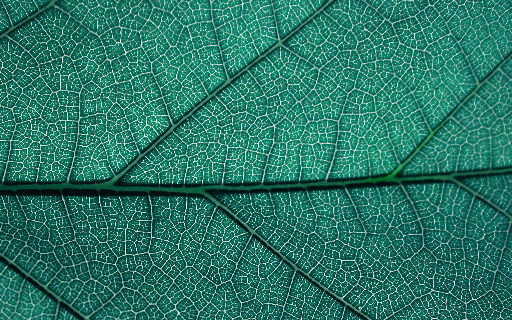

Iteration: 0
Total loss: 4.7250e+04,  Learning rate =  10


In [0]:
#tf.reset_default_graph()
img=neural_texture_train(content_path, texture_path, loss_weights = (5.0,1,0,5e-5), 
                        split = (1,1), layers = (content_layers, texture_layers))